## Chapter 1 Introduction

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Convective heat transfer: Heat transfer flux solver 
def radiation_heat_flux_black_body(coeff_conv, t_surface, t_fluid):
    '''
    Solve for the convection process heat transfer flux using Newton's law of cooling

    Inputs:
    coeff_conv      convective heat transfer coefficient
    t_surface       temperature of controlled surface
    t_fluid         temperature of bluk fluid flowing around the surface
    '''
    q_flux_conv = coeff_conv * (t_surface-t_fluid)
    return q_flux_conv

# Convective heat transfer: Surface temperature solver
def convection_t_surface(q_flux_conv, coeff_conv, t_fluid):
    '''
    Solve for the convection process surface temperature using Newton's law of cooling

    Inputs:
    q_flux_conv     convective heat transfer flux
    coeff_conv      convective heat transfer coefficient
    t_fluid         temperature of bluk fluid flowing around the surface
    '''
    t_surface = (q_flux_conv / coeff_conv) + t_fluid
    return t_surface

In [7]:
# Radiation heat transfer: Heat transfer flux solver 
def radiation_heat_flux_black_body(emissivity, t_surface, t_surroundings):
    '''
    Solve for the radiation process heat transfer flux using Stefan-Boltzmann equation
    Assuming a black body radiation of a small body inside a large compartment
    
    Inputs:
    emissivity      control surface emissive property, assumed to equate the absobtivity property
    t_surface       temperature of controlled surface
    t_surrpoundings temperature of large surface surrounding the small surface 
    '''
    const_stefan_boltzmann = 5.67*10^-8
    q_flux_rad = const_stefan_boltzmann * emissivity * (t_surface-t_surroundings)
    return q_flux_rad

# Radiation heat transfer: Surface temperature solver
def radiation_t_surface(q_flux_rad, emissivity, t_surface, t_surroundings):
    '''
    Solve for the radiation process surface temperature using Stefan-Boltzmann equation

    Inputs:
    q_flux_rad      radiation heat transfer flux
    emissivity      control surface emissive property, assumed to equate the absobtivity property
    t_surface       temperature of controlled surface
    t_surrpoundings temperature of large surface surrounding the small surface 
    '''
    const_stefan_boltzmann = 5.67*10^-8
    t_surface = ((q_flux_rad / const_stefan_boltzmann / emissivity) + t_surroundings**4)**(1/4)
    return t_surface

In [62]:
# Example 1.4 
# Long conducting rod with current flow inside a large surface
# Solve for surface temperature as a function of time
 
import scipy as sp
from scipy.integrate import odeint
from scipy.integrate import solve_bvp

# Define the function dt_surf_dt as a function of the surface temperature and time
# Solver for surface temperature over time of energy balance differential equation
def dt_suf_dt(t, t_surface):
    # Rod dimensions:
    rod_diameter    = 0.001     # meters
    rod_length      = 0.5       # meters
    rod_cross_area  = np.pi*(rod_diameter/2)**2  # cross-sectional area in m^2
    rod_volume      = rod_cross_area * rod_length

    # Rod material properties:
    rod_density         = 7800  # kg/m^3 (steel)
    rod_specific_heat   = 500   # J/(kg*K) (steel)
    rod_mass            = rod_density * rod_volume  # mass in kg

    # Energy gen - Electrical power
    current             = 5         # I (current through rod)
    resistance_per_L    = 0.4       # Ohms (resistance of the rod)
    energy_gen          = current**2 * resistance_per_L  * rod_length    # W (power generated by rod)

    # Environment convection
    t_fluid             = 300       # K (ambient temperature)
    contective_coeff    = 100       # W/(m^2*K) (convection heat transfer coefficient)

    # Environment radiation
    t_large_surface = 300       # K (temperature of the large surface area)
    emissivity      = 0.8       # emissivity of the rod surface
    sigma           = 5.67e-8   # W/(m^2*K^4) (Stefan-Boltzmann constant)

    return (energy_gen - contective_coeff*np.pi*rod_diameter*rod_length*(t_surface-t_fluid) - emissivity*sigma*np.pi*rod_diameter*rod_length*(t_surface**4 - t_large_surface**4)) / (rod_density*rod_specific_heat*np.pi*(rod_diameter**2)/4)


Use SciPy odeint solver 

330.1181059909622


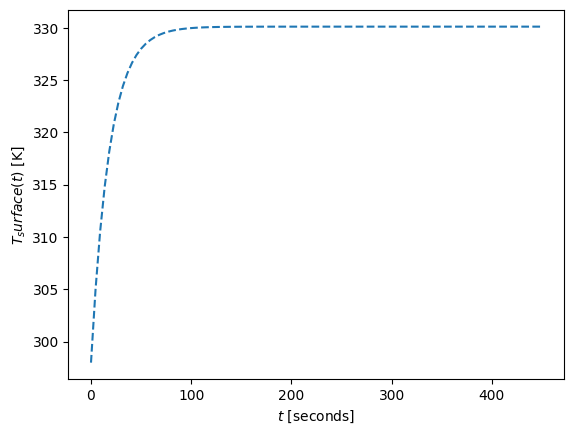

In [ ]:
t = np.linspace(0,450,100)      # Set the time range

t_surf0 = 298                   # Initial condition
t_surf_sol = odeint(dt_suf_dt, y0=t_surf0, t=t, tfirst=True)
t_surf_sol.T[0]
print(max(t_surf_sol.T[0]))

# Plot
plt.plot(t, t_surf_sol, '--')
plt.ylabel('$T_surface(t)$ [K]')
plt.xlabel('$t$ [seconds]')
plt.show()

300.0000000005368


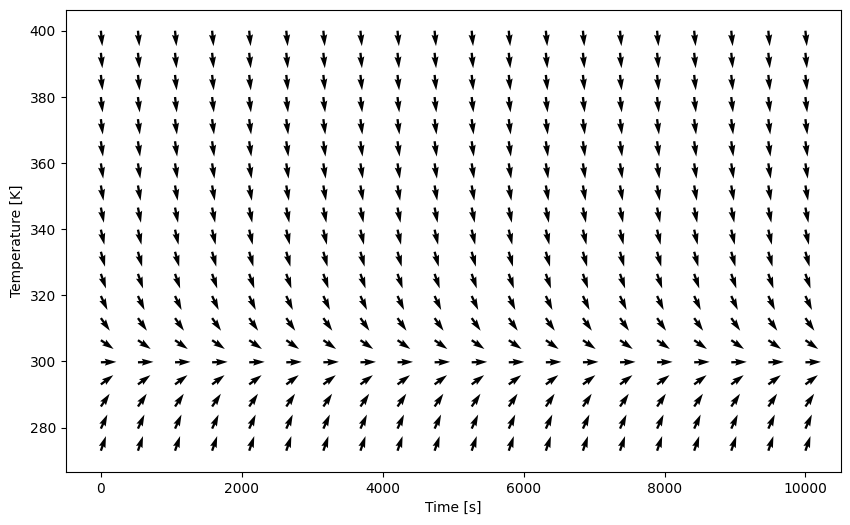

In [ ]:
# Solve a simpler case than Example 1.4
# Assume there is no heat generation

# Rod dimensions:
rod_diameter    = 0.001     # meters
rod_length      = 0.5       # meters
rod_cross_area  = np.pi*(rod_diameter/2)**2  # cross-sectional area in m^2
rod_volume      = rod_cross_area * rod_length

# Rod material properties:
rod_density         = 7800  # kg/m^3 (steel)
rod_specific_heat   = 500   # J/(kg*K) (steel)
rod_mass            = rod_density * rod_volume  # mass in kg

# Environment convection
t_fluid             = 300       # K (ambient temperature)
contective_coeff    = 100       # W/(m^2*K) (convection heat transfer coefficient)

# Environment radiation
t_large_surface = 300       # K (temperature of the large surface area)
emissivity      = 0.8       # emissivity of the rod surface
sigma           = 5.67e-8   # W/(m^2*K^4) (Stefan-Boltzmann constant)


# Compute dT/dt
t           = np.linspace(0,10000,20)
temp_surf   = np.linspace(273,400,20)
t_surf_grid, t_grid = np.meshgrid(temp_surf, t)
dT_dt = -4*contective_coeff*(t_surf_grid - t_fluid)/(rod_density*rod_specific_heat*rod_diameter) - 4*emissivity*sigma*(t_surf_grid**4 - t_large_surface**4)/(rod_density*rod_specific_heat*rod_diameter)

# Get one solution
def dT_dt_solver(t_surf, t):
    return -4*contective_coeff*(t_surf - t_fluid)/(rod_density*rod_specific_heat*rod_diameter) - 4*emissivity*sigma*(t_surf**4 - t_large_surface**4)/(rod_density*rod_specific_heat*rod_diameter)
t_surf0     = 298                   # Initial condition
t_surf_sol  = odeint(dT_dt_solver, y0=t_surf0, t=t)
t_surf_sol.T[0]
print(max(t_surf_sol.T[0]))

# Normalize vectors
u = 1
v = dT_dt
magnitude = np.sqrt(u**2 + v**2)
u_norm = u / magnitude  
v_norm = v / magnitude

# Plot vector field
plt.figure(figsize=(10,6))
plt.xlabel('Time [s]')
plt.ylabel('Temperature [K]')
plt.quiver(t_grid, t_surf_grid, u_norm, v_norm, scale=50)
plt.grid(False)
plt.show()


In [3]:
# Modified secant method
def modified_secant(f_x, target_f_x, x_0, f_x_params, dx=0.1, error_stop_criterion=1e-10, iter_max=100):
    '''
    Iterate to find the x value that corresponds to when f_x is equal to a target_f_x value
    Assumes there is only one root
    
    Inputs:
    f                   function to find the roots
    x_0                 initial guess
    dx                  perturbation parameter for modified secant method
    error_criterion     iteration error must be below error_criterion to end computation
    iter_max            maximum number of iterations allowed above which computation ends
    '''
    # Initial iteration values
    i = 0               
    x_i             = x_0
    f_i             = f_x(x_i, f_x_params) - target_f_x
    error_i         = None
    
    # Create dataframe to record iteration values
    dict_iter    = {'Iteration': [i], 'x_i':[x_i], 'f_i':[f_i], 'error_i':[error_i]}
    df_iter      = pd.DataFrame(dict_iter).set_index('Iteration')

    while (error_i == None) or (error_i > error_stop_criterion):        
        # Compute new estimate
        f_dx_i          = f_x(x_i+dx, f_x_params) - target_f_x
        f_deriv_i       = (f_dx_i - f_i) / dx
        x_i_new         = x_i - f_i/f_deriv_i 
        f_i_new         = f_x(x_i_new, f_x_params) - target_f_x
        error_i_new     = abs((x_i_new - x_i)/x_i_new)

        # Set and check the next iteration number
        if i == iter_max:   
            print('stopped due to iteration max')
            break
        
        # Set the next iteration x_i and f_i values
        i+=1
        x_i     = x_i_new
        f_i     = f_i_new
        error_i = error_i_new
        df_iter.loc[len(df_iter)] = [x_i, f_i+target_f_x, error_i]

    # Display the dataframe of iteration
    return x_i, f_i+target_f_x, error_i, df_iter